# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Randomly Generated Data with Three Classes

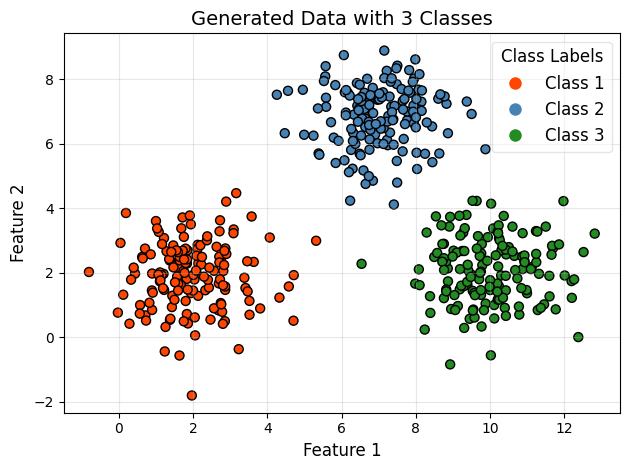

In [2]:
# Function to generate synthetic data
def generate_data(samples_per_class=150):
    np.random.seed(50)
    # Class 1: Centered at (2, 2)
    class_1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    # Class 2: Centered at (67, 7)
    class_2 = np.random.randn(samples_per_class, 2) + np.array([7, 7])
    # Class 3: Centered at (10, 2)
    class_3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])

    # Combine the data
    x_data = np.vstack([class_1, class_2, class_3])
    y_data = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class)
    return x_data, y_data

# Generate and visualize the data
x_data, y_data = generate_data()

# Define the colors for each class
class_colors = ['#FF4500', '#4682B4', '#228B22']

# Scatter plot with specific colors for the classes
plt.scatter(x_data[:, 0], x_data[:, 1], c=[class_colors[i] for i in y_data], s=42, edgecolor='k')

# Adding title and labels
plt.title("Generated Data with 3 Classes", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Define the legend elements with the specific colors you provided
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Class {i+1}')
                   for i, color in enumerate(class_colors)]

# Add the legend inside a box with specific colors
plt.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True,
           framealpha=0.5, title="Class Labels", title_fontsize=12)

# Display grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot with adjusted layout to avoid overlap
plt.tight_layout()
plt.show()

# Prepare Data (Preprocessing)

In [3]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y_data.reshape(-1, 1))

# Split the data into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_encoded, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")

Train set: 270 samples
Validation set: 90 samples
Test set: 90 samples


# Define the Neural Network

In [4]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr=0.01):
        # Initialize weights for all layers
        self.W1 = np.random.randn(input_size, hidden_size1)  # Input to Hidden Layer 1
        self.W2 = np.random.randn(hidden_size1, hidden_size2)  # Hidden Layer 1 to Hidden Layer 2
        self.W3 = np.random.randn(hidden_size2, hidden_size3)  # Hidden Layer 2 to Hidden Layer 3
        self.W4 = np.random.randn(hidden_size3, output_size)  # Hidden Layer 3 to Output Layer
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feed_forward(self, x):
        # Layer 1
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        # Layer 2
        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        # Layer 3
        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        # Output Layer
        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.sigmoid(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        # Output Layer Error
        output_error = y - output
        output_delta = output_error * self.sigmoid(output, derivative=True)

        # Hidden Layer 3 Error
        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        # Hidden Layer 2 Error
        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        # Hidden Layer 1 Error
        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        # Update weights
        self.W4 += np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 += np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 += np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 += np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

# Train the Neural Network

In [5]:
input_size = x_train.shape[1]
hidden_size1 = 10  # Neurons in the first hidden layer
hidden_size2 = 10  # Neurons in the second hidden layer
hidden_size3 = 10  # Neurons in the third hidden layer
output_size = y_train.shape[1]  # Number of output classes
learning_rate = 0.001  # Learning rate
epochs = 800

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, learning_rate)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(x_train, y_train)
    train_output = nn.feed_forward(x_train)
    val_output = nn.feed_forward(x_val)

    # Compute loss
    train_loss = np.mean((y_train - train_output) ** 2)
    val_loss = np.mean((y_val - val_output) ** 2)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Compute accuracy
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}, "
              f"Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")

Epoch 0: Train Loss = 0.4152, Validation Loss = 0.3921, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 20: Train Loss = 0.3796, Validation Loss = 0.3529, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 40: Train Loss = 0.3763, Validation Loss = 0.3485, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 60: Train Loss = 0.3752, Validation Loss = 0.3471, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 80: Train Loss = 0.3741, Validation Loss = 0.3459, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 100: Train Loss = 0.3728, Validation Loss = 0.3447, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 120: Train Loss = 0.3711, Validation Loss = 0.3431, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 140: Train Loss = 0.3683, Validation Loss = 0.3406, Train Accuracy = 31.11%, Validation Accuracy = 37.78%
Epoch 160: Train Loss = 0.3627, Validation Loss = 0.3352, Train Accuracy = 31.11%, Validation Accuracy = 37.78

# Visualize Loss and Accuracy

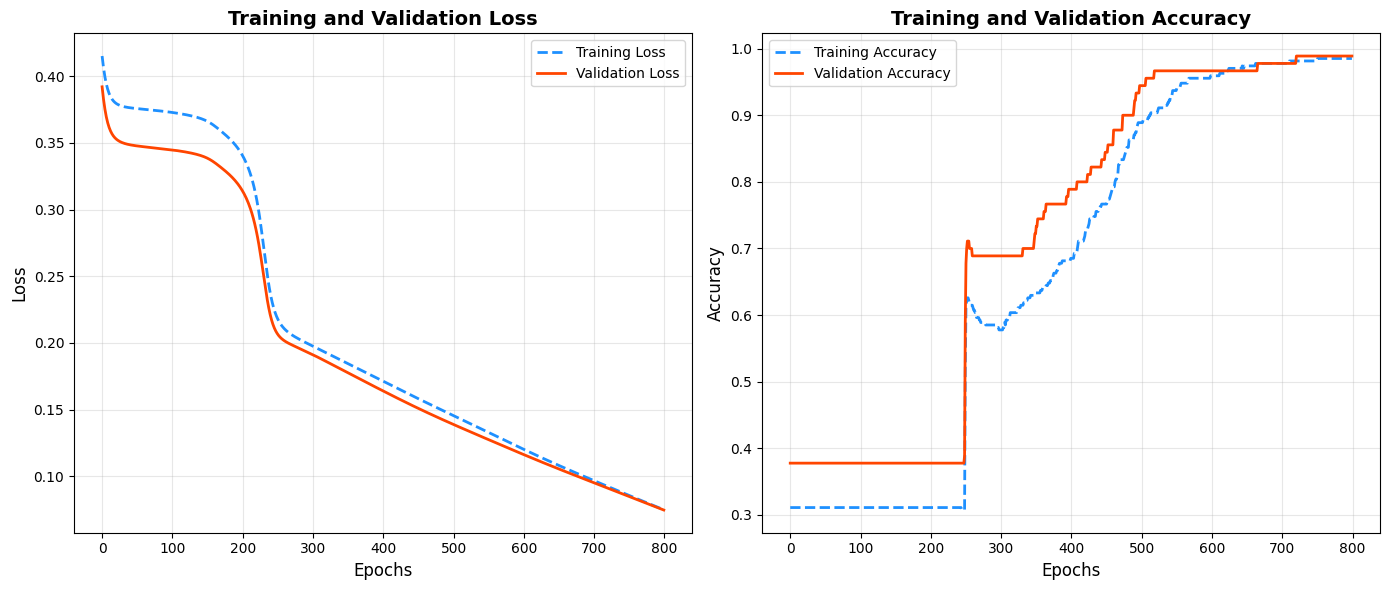

In [6]:
# Plotting Training and Validation Loss
plt.figure(figsize=(14, 6))

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)  # First subplot for loss

# Plot training and validation losses
plt.plot(train_losses, label="Training Loss", linestyle='--', linewidth=2, color='dodgerblue')
plt.plot(val_losses, label="Validation Loss", linestyle='-', linewidth=2, color='orangered')

# Add labels, title, and grid
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)  # Enhanced grid for readability

plt.subplot(1, 2, 2)  # Second subplot for accuracy

# Plot training and validation accuracies
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--', linewidth=2, color='dodgerblue')
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='-', linewidth=2, color='orangered')

# Add labels, title, and grid
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)  # Enhanced grid for readability

# Adjust layout for better presentation
plt.tight_layout()
plt.show()

# Visualize Comparison of Predicted vs Actual Classes

<ipython-input-7-c612f5cb868a>:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_test[actual_classes == i, 0], x_test[actual_classes == i, 1],


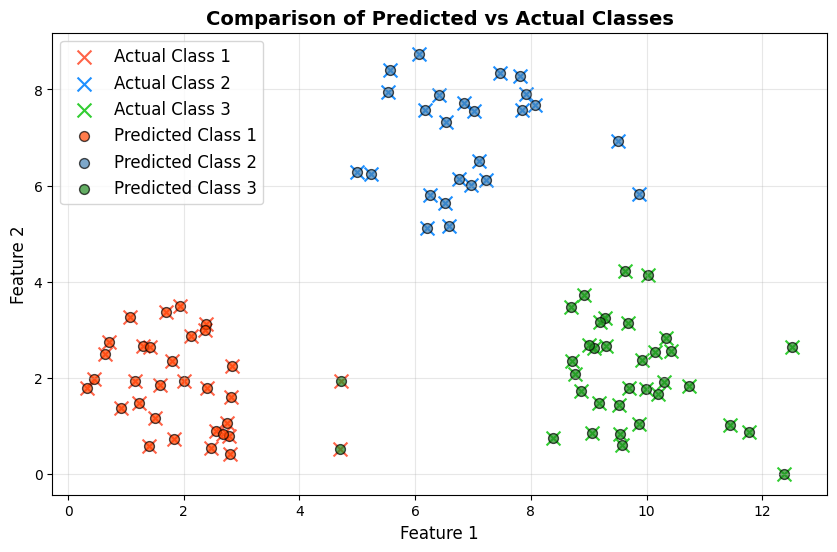

In [7]:
# Predict output from the neural network
predicted_output = nn.feed_forward(x_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Visualize the comparison without decision boundary
plt.figure(figsize=(10, 6))

# Scatter plot for actual test classes (represented with 'x' markers)
# Assign specific colors for each class for clarity
colors_actual = ['#FF6347', '#1E90FF', '#32CD32']  # Tomato, DodgerBlue, LimeGreen for three classes
for i in range(3):
    plt.scatter(x_test[actual_classes == i, 0], x_test[actual_classes == i, 1],
                c=colors_actual[i], s=100, marker='x', edgecolor='k', label=f'Actual Class {i+1}')

# Scatter plot for predicted classes (represented with 'o' markers)
# Assign distinct colors for predicted classes
colors_predicted = ['#FF4500', '#4682B4', '#228B22']  # OrangeRed, SteelBlue, ForestGreen for predicted classes
for i in range(3):
    plt.scatter(x_test[predicted_classes == i, 0], x_test[predicted_classes == i, 1],
                c=colors_predicted[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=f'Predicted Class {i+1}')

# Adding title and labels
plt.title("Comparison of Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend to differentiate between actual and predicted classes
plt.legend(loc="best", fontsize=12)

# Display grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

# Visualize Decision Boundary and Comparison of Predicted vs Actual Classes

<ipython-input-8-3a23bb10716e>:29: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_test[actual_classes == i, 0], x_test[actual_classes == i, 1],


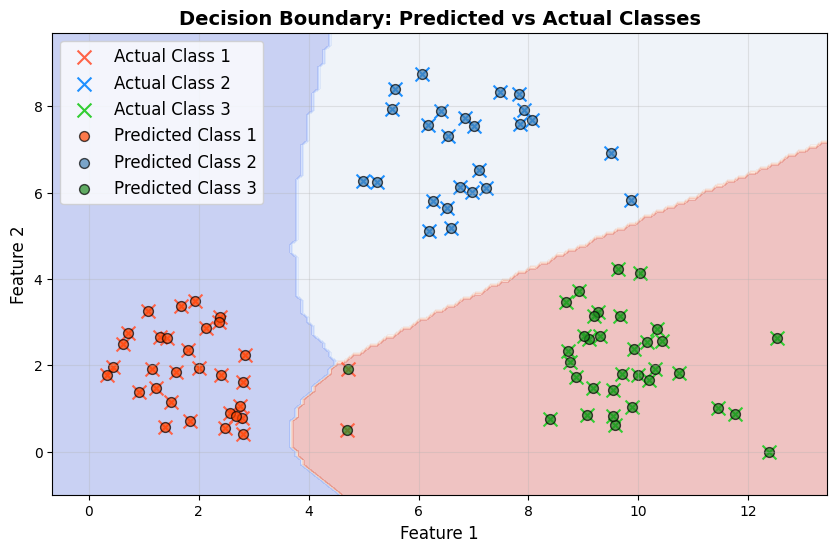

In [8]:
# Predict output from the neural network
predicted_output = nn.feed_forward(x_test)

# Convert predicted output and actual labels to class labels
predicted_classes = np.argmax(predicted_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)

# Generate meshgrid for decision boundary plotting
x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1  # Define x-axis limits
y_min, y_max = x_test[:, 1].min() - 1, x_test[:, 1].max() + 1  # Define y-axis limits

# Create a grid of points (xx, yy) covering the entire feature space
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict the class for each point in the meshgrid to visualize decision boundary
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)  # Reshape the predicted class array to match the shape of the meshgrid

# Visualize the decision boundary and comparison between predicted vs actual
plt.figure(figsize=(10, 6))

# Plot the decision boundary using a contour plot with suitable color map for clarity
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')  # 'coolwarm' colormap for a neutral background

# Scatter plot for actual test classes (represented with 'x' markers)
# Assign specific colors for each class for clarity
colors_actual = ['#FF6347', '#1E90FF', '#32CD32']  # Tomato, DodgerBlue, LimeGreen for three classes
for i in range(3):
    plt.scatter(x_test[actual_classes == i, 0], x_test[actual_classes == i, 1],
                c=colors_actual[i], s=100, marker='x', edgecolor='k', label=f'Actual Class {i+1}')

# Scatter plot for predicted classes (represented with 'o' markers)
# Assign distinct colors for predicted classes
colors_predicted = ['#FF4500', '#4682B4', '#228B22']  # OrangeRed, SteelBlue, ForestGreen for predicted classes
for i in range(3):
    plt.scatter(x_test[predicted_classes == i, 0], x_test[predicted_classes == i, 1],
                c=colors_predicted[i], s=50, marker='o', edgecolor='k', alpha=0.7, label=f'Predicted Class {i+1}')

# Adding title and labels
plt.title("Decision Boundary: Predicted vs Actual Classes", fontsize=14, fontweight='bold')
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)

# Add legend to differentiate between actual and predicted classes
plt.legend(loc="best", fontsize=12)

# Display grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()